In [1]:
"""Exploratory Data Analysis - Part 1: Data Information and Missing Data Analysis."""

'Exploratory Data Analysis - Part 1: Data Information and Missing Data Analysis.'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [4]:
# Load the data
print("="*70)
print("LOADING DATA")
print("="*70)
df_raw = pd.read_excel("data/input_data_sun_heavy.xlsx")

# Convert first column to datetime and set as index
df_raw["Unnamed: 0"] = pd.to_datetime(df_raw["Unnamed: 0"])
df_raw = df_raw.rename(columns={"Unnamed: 0": "datetime"})
df_raw = df_raw.set_index("datetime")

print(f"Raw data loaded: {df_raw.shape}")
print(f"Raw date range: {df_raw.index.min().date()} to {df_raw.index.max().date()}")

LOADING DATA


Raw data loaded: (35041, 44)
Raw date range: 2023-01-01 to 2024-01-01


In [5]:
# Resample to 15-minute intervals
print("\n" + "="*70)
print("RESAMPLING TO 15-MINUTE INTERVALS")
print("="*70)

# Create complete 15-minute time index
start_time = df_raw.index.min().floor('15min')
end_time = df_raw.index.max().ceil('15min')
complete_index = pd.date_range(start=start_time, end=end_time, freq='15min')

missing_intervals = len(complete_index) - len(df_raw)

if missing_intervals == 0:
    print("Data is already at 15-minute intervals. No resampling needed.")
    df = df_raw
else:
    print(f"Expected 15-min intervals: {len(complete_index):,}")
    print(f"Actual raw data points: {len(df_raw):,}")
    print(f"Missing intervals to fill: {missing_intervals:,}")

    # Reindex to complete 15-minute grid
    df = df_raw.reindex(complete_index)

    print(f"\nResampled data shape: {df.shape}")
    print(f"Resampled date range: {df.index.min().date()} to {df.index.max().date()}")


RESAMPLING TO 15-MINUTE INTERVALS
Data is already at 15-minute intervals. No resampling needed.


In [6]:
# Data Information Summary
print("\n" + "="*70)
print("DATA INFORMATION SUMMARY")
print("="*70)

# Basic counts
n_observations = len(df)
date_begin = df.index.min().date()
date_end = df.index.max().date()
n_days = (df.index.max() - df.index.min()).days

# Target variable
target_col = 'load'
n_missing_y = df[target_col].isna().sum()
pct_missing_y = (n_missing_y / n_observations) * 100

# Feature variables (all except load)
feature_cols = [col for col in df.columns if col != target_col]
n_x_variables = len(feature_cols)

# Missing X (any feature missing)
missing_x = df[feature_cols].isnull().any(axis=1)
n_missing_x = missing_x.sum()
pct_missing_x = (n_missing_x / n_observations) * 100

# Complete observations (both X and y present)
complete_obs = ~(df[target_col].isna() | missing_x)
n_complete = complete_obs.sum()
pct_complete = (n_complete / n_observations) * 100

print(f"\nNumber of observations: {n_observations:,}")
print(f"Date range: {date_begin} to {date_end} ({n_days} days)")
print(f"\nTarget variable: '{target_col}'")
print(f"  - Missing values: {n_missing_y:,} ({pct_missing_y:.2f}%)")
print(f"\nFeature variables (X):")
print(f"  - Number of variables: {n_x_variables}")
print(f"  - Observations with any missing feature: {n_missing_x:,} ({pct_missing_x:.2f}%)")
print(f"\nComplete observations (X + y both present): {n_complete:,} ({pct_complete:.2f}%)")


DATA INFORMATION SUMMARY

Number of observations: 35,041
Date range: 2023-01-01 to 2024-01-01 (365 days)

Target variable: 'load'
  - Missing values: 22 (0.06%)

Feature variables (X):
  - Number of variables: 43
  - Observations with any missing feature: 1,649 (4.71%)

Complete observations (X + y both present): 33,370 (95.23%)


In [7]:
# Gap Analysis - Helper function
def find_consecutive_gaps(mask):
    """
    Find start/end indices and lengths of runs of True in a boolean Series/array.
    Returns list of (start_idx, end_idx) tuples (end is inclusive).
    """
    arr = mask.values
    n = len(arr)
    if n == 0:
        return []

    # Pad with False at both ends to handle edge cases
    padded = np.concatenate([[False], arr, [False]])
    diff = np.diff(padded.astype(int))

    gap_starts = np.where(diff == 1)[0]
    gap_ends = np.where(diff == -1)[0] - 1

    gaps = list(zip(gap_starts, gap_ends))
    return gaps

In [8]:
# Gap Analysis
print("\n" + "="*70)
print("MISSING DATA GAP ANALYSIS")
print("="*70)

# Analyze gaps for target, features, and overall
gap_analyses = {
    'Target (load)': df[target_col].isna(),
    'Features (X)': missing_x,
    'Overall (any)': df[target_col].isna() | missing_x
}

all_gap_results = {}

for gap_type, missing_mask in gap_analyses.items():
    print(f"\n{gap_type}:")
    print("-"*70)

    gaps = find_consecutive_gaps(missing_mask)

    if len(gaps) == 0:
        print("  No missing data gaps found!")
        all_gap_results[gap_type] = None
        continue

    # Calculate gap information
    gaps_info = []
    for start_idx, end_idx in gaps:
        gap_len = end_idx - start_idx + 1
        gap_start_time = df.index[start_idx]
        gap_end_time = df.index[end_idx]
        gap_duration_days = (gap_end_time - gap_start_time).total_seconds() / (3600 * 24)

        gaps_info.append({
            'gap_id': len(gaps_info) + 1,
            'start_idx': start_idx,
            'end_idx': end_idx,
            'n_observations_missing': gap_len,
            'start_date': gap_start_time.date(),
            'end_date': gap_end_time.date(),
            'duration_days': gap_duration_days,
        })

    gaps_df = pd.DataFrame(gaps_info)
    gaps_df_sorted = gaps_df.sort_values('duration_days', ascending=False)
    all_gap_results[gap_type] = gaps_df_sorted

    print(f"  Total gaps: {len(gaps_df)}")
    print(f"  Total missing observations: {gaps_df['n_observations_missing'].sum():,}")
    print(f"  Average gap size: {gaps_df['n_observations_missing'].mean():.1f} observations")
    print(f"  Median gap size: {gaps_df['n_observations_missing'].median():.0f} observations")
    print(f"  Largest gap: {gaps_df['n_observations_missing'].max():,} observations "
          f"({gaps_df['duration_days'].max():.2f} days)")

    # Show top 10 largest gaps
    if len(gaps_df_sorted) > 0:
        print(f"\n  Top 10 Largest Gaps:")
        print(f"  {'#':<5} {'Start Date':<15} {'End Date':<15} {'Days':<10} {'Obs':<10}")
        print("  " + "-"*60)
        for idx, (_, gap) in enumerate(gaps_df_sorted.head(10).iterrows(), 1):
            print(f"  {idx:<5} "
                  f"{str(gap['start_date']):<15} "
                  f"{str(gap['end_date']):<15} "
                  f"{gap['duration_days']:<10.2f} "
                  f"{gap['n_observations_missing']:<10}")


MISSING DATA GAP ANALYSIS

Target (load):
----------------------------------------------------------------------
  Total gaps: 3
  Total missing observations: 22
  Average gap size: 7.3 observations
  Median gap size: 5 observations
  Largest gap: 16 observations (0.16 days)

  Top 10 Largest Gaps:
  #     Start Date      End Date        Days       Obs       
  ------------------------------------------------------------
  1     2023-05-23      2023-05-23      0.16       16        
  2     2023-10-29      2023-10-29      0.04       5         
  3     2023-01-01      2023-01-01      0.00       1         

Features (X):
----------------------------------------------------------------------
  Total gaps: 4
  Total missing observations: 1,649
  Average gap size: 412.2 observations
  Median gap size: 155 observations
  Largest gap: 1,335 observations (13.90 days)

  Top 10 Largest Gaps:
  #     Start Date      End Date        Days       Obs       
  ----------------------------------------

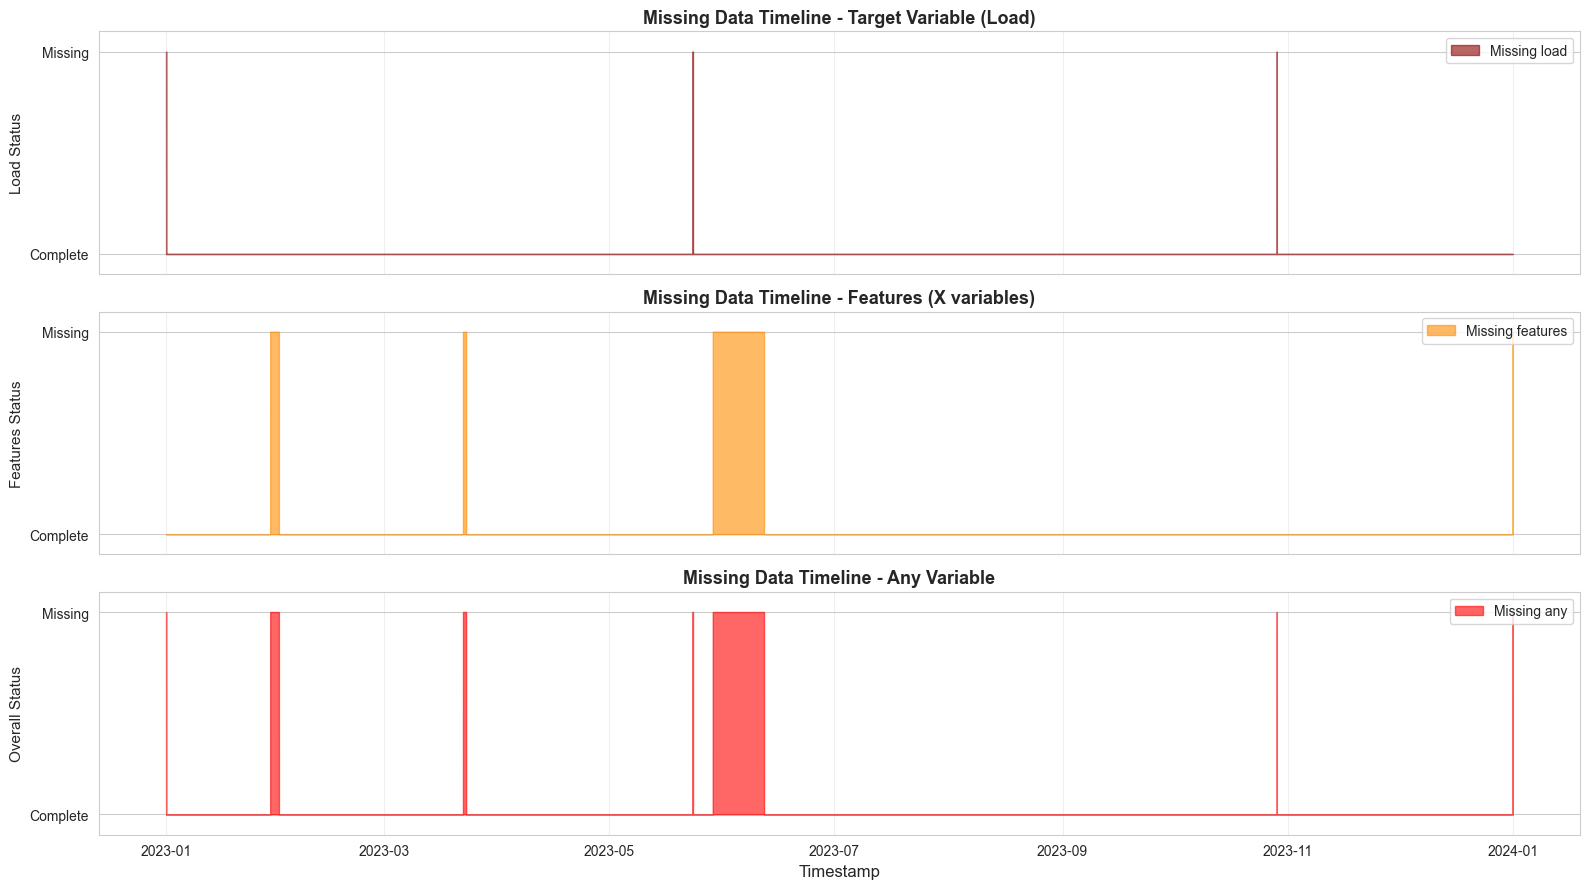

In [9]:
# Visualize missing data timeline
fig, axes = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

# Plot 1: Missing target variable
axes[0].fill_between(df.index, 0, df[target_col].isna().astype(int),
                      alpha=0.6, color='darkred', label='Missing load')
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Complete', 'Missing'])
axes[0].set_ylabel('Load Status', fontsize=11)
axes[0].set_title('Missing Data Timeline - Target Variable (Load)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].legend(loc='upper right')

# Plot 2: Missing features
axes[1].fill_between(df.index, 0, missing_x.astype(int),
                      alpha=0.6, color='darkorange', label='Missing features')
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Complete', 'Missing'])
axes[1].set_ylabel('Features Status', fontsize=11)
axes[1].set_title('Missing Data Timeline - Features (X variables)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].legend(loc='upper right')

# Plot 3: Missing any
axes[2].fill_between(df.index, 0, (df[target_col].isna() | missing_x).astype(int),
                      alpha=0.6, color='red', label='Missing any')
axes[2].set_ylim(-0.1, 1.1)
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Complete', 'Missing'])
axes[2].set_xlabel('Timestamp', fontsize=12)
axes[2].set_ylabel('Overall Status', fontsize=11)
axes[2].set_title('Missing Data Timeline - Any Variable', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
# Categorize variables based on documentation
print("\n" + "="*70)
print("VARIABLE CATEGORIZATION")
print("="*70)

# Define variable groups based on naming patterns
load_vars = ['load']

# Weather/climate variables (temperature, humidity, pressure, wind, radiation, cloud, clearsky, mxld, snowdepth)
weather_vars = [col for col in df.columns if any(keyword in col.lower() for keyword in
    ['temperature', 'temp', 'humidity', 'pressure', 'wind', 'radiation', 'cloud', 'weather',
     'clearsky', 'mxld', 'snowdepth'])]

# Pricing variables
pricing_vars = [col for col in df.columns if any(keyword in col.lower() for keyword in
    ['price', 'epex', 'apx'])]

# Load profile variables (remaining variables not in other categories)
profile_vars = [col for col in df.columns if col not in load_vars + weather_vars + pricing_vars]

print(f"\nLoad variables ({len(load_vars)}): {load_vars}")

print(f"\nWeather/Climate variables ({len(weather_vars)}):")
for var in weather_vars:
    print(f"  - {var}")

print(f"\nPricing variables ({len(pricing_vars)}): {pricing_vars if pricing_vars else 'None found'}")

print(f"\nLoad profile variables ({len(profile_vars)}):")
for var in profile_vars:
    print(f"  - {var}")


VARIABLE CATEGORIZATION

Load variables (1): ['load']

Weather/Climate variables (12):
  - clearSky_dlf
  - clearSky_ulf
  - clouds
  - humidity
  - mxlD
  - pressure
  - radiation
  - snowDepth
  - temp
  - winddeg
  - windspeed
  - windspeed_100m

Pricing variables (1): ['APX']

Load profile variables (30):
  - E1A_AMI_A
  - E1A_AMI_I
  - E1A_AZI_A
  - E1A_AZI_I
  - E1B_AMI_A
  - E1B_AMI_I
  - E1B_AZI_A
  - E1B_AZI_I
  - E1C_AMI_A
  - E1C_AMI_I
  - E1C_AZI_A
  - E1C_AZI_I
  - E2A_AMI_A
  - E2A_AMI_I
  - E2A_AZI_A
  - E2A_AZI_I
  - E2B_AMI_A
  - E2B_AMI_I
  - E2B_AZI_A
  - E2B_AZI_I
  - E3A_A
  - E3A_I
  - E3B_A
  - E3B_I
  - E3C_A
  - E3C_I
  - E3D_A
  - E3D_I
  - E4A_A
  - E4A_I


In [11]:
print("\n" + "="*70)
print("EDA PART 1 (DATA INFO) COMPLETE")
print("="*70)


EDA PART 1 (DATA INFO) COMPLETE
